# transversity-combined

In [1]:
import sys,os
os.chdir('../../')
import itertools as it
import numpy as np
import pandas as pd
from scipy.special import beta
from scipy.integrate import quad
import pylab as py
from  matplotlib import rc
from matplotlib.colors import LogNorm
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)
import matplotlib
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tools.tools import save,load,lprint,load_config
from tools.bar import BAR
from resman import RESMAN
import nest
import obslib.moments.moments

In [2]:
best1=4 # from only sidis run
best2=4 # from sidis+lattice run

## setup

In [3]:
class RUN:
    
    def __init__(self,path,nestfile,inputfile):
        self.conf=conf=load_config('%s/%s'%(path,inputfile))
        self.resman=RESMAN(self.conf);
        self.parman=self.resman.conf['parman']
        nest=load('%s/%s'%(path,nestfile))
        wmax=np.amax(nest['weights'])
        wmin_cut=wmax*1e-7
        self.weights=[nest['weights'][j] for j in range(len(nest['weights'])) if nest['weights'][j]>wmin_cut]
        self.samples=[nest['samples'][j] for j in range(len(nest['weights'])) if nest['weights'][j]>wmin_cut]
        self.weights/=np.sum(self.weights)
        self.moments=obslib.moments.moments.MOMENTS(self.conf)
        self.nest=nest

In [4]:
path='outputs/transversity/transversity-0'
nestfile='nest%d'%best1
inputfile='transversity-0.py'
run1=RUN(path,nestfile,inputfile)

SyntaxError: invalid syntax (<string>, line 1)

In [6]:
path='outputs/transversity/transversity-1'
nestfile='nest%d'%best2
inputfile='transversity-1.py'
run2=RUN(path,nestfile,inputfile)

IOError: [Errno 2] No such file or directory: 'outputs/transversity/transversity-1/transversity-1.py'

In [7]:
print 'run1 LogZ =',run1.nest['logz'][-1]
print 'run2 LogZ =',run2.nest['logz'][-1]

run1 LogZ = 36.249833538
run2 LogZ =

NameError: name 'run2' is not defined

In [8]:
def get_kinematics():
    tabs=run1.resman.sidisres.tabs
    X,Z,Q2,pT=[],[],[],[]
    for k in tabs:X=np.append(tabs[k]['x'],X)
    for k in tabs:Z=np.append(tabs[k]['z'],Z)
    for k in tabs:Q2=np.append(tabs[k]['Q2'],Q2)
    for k in tabs:pT=np.append(tabs[k]['pT'],pT)
    return {'X':X,'Z':Z,'Q2':Q2,'pT':pT}
kin=get_kinematics()

## PDFs and FFs

In [10]:
def calc(run,func,msg):
    RAW=[]
    bar=BAR(msg,len(run.samples))
    for i in range(len(run.samples)):
        par=run.samples[i]
        run.parman.set_new_params(par)
        RAW.append(func())
        bar.next()
    bar.finish()
    RAW=np.array(RAW)
    f =np.einsum('k,kif->if',run.weights,RAW)
    df=np.einsum('k,kif->if',run.weights,(RAW-f)**2)**0.5
    f=np.einsum('if->fi',f)
    df=np.einsum('if->fi',df)
    return {'f':f,'df':df}

## Transversity

In [11]:
X1=10**np.linspace(-3,-1)
X2=np.linspace(0.101,0.999)
X=np.append(X1,X2)
h1=calc(run1,lambda : [run1.resman.conf['transversity'].get_C(x,1) for x in X],'calc h1')
h2=calc(run2,lambda : [run2.resman.conf['transversity'].get_C(x,1) for x in X],'calc h2')

calc h1 [100%]
calc h2 [100%]


In [12]:
Z1=10**np.linspace(-3,-1)
Z2=np.linspace(0.101,0.999)
Z=np.append(Z1,Z2)
Hpi1=calc(run1,lambda : [run1.resman.conf['collins'].get_C(z,1,'pi+') for z in Z],'calc H(pi+)')
Hpi2=calc(run2,lambda : [run2.resman.conf['collins'].get_C(z,1,'pi+') for z in Z],'calc H(pi+)')
#Hk1=calc(run1,lambda : [run1.resman.conf['collins'].get_C(z,1,'k+') for z in Z],'calc H(k+)')
Hk2=calc(run2,lambda : [run2.resman.conf['collins'].get_C(z,1,'k+') for z in Z],'calc H(k+)')

calc H(pi+) [100%]
calc H(pi+) [100%]
calc H(k+) [100%]


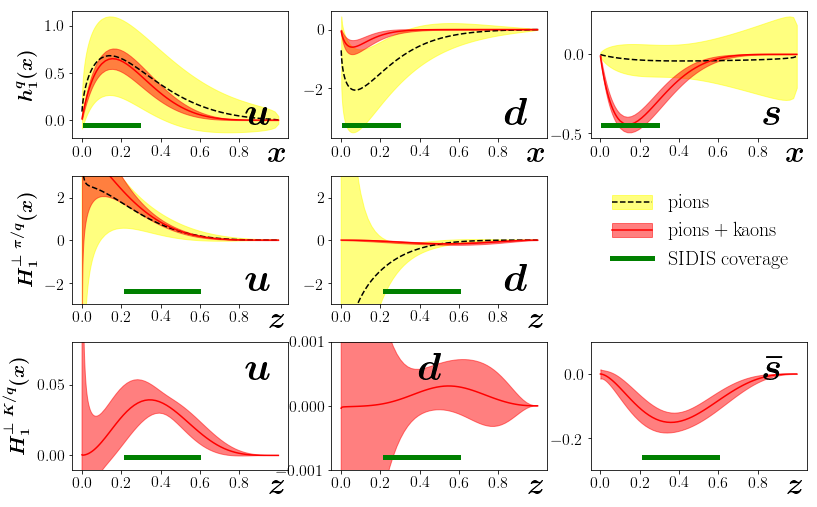

In [25]:
nrows,ncols=3,3
py.figure(figsize=(ncols*4,nrows*2.5))

def plot(idx,flav,legend=False,ylims=None):
    ax=py.subplot(nrows,ncols,idx)
    band1=ax.fill_between(X,(h1['f'][flav]-h1['df'][flav]),(h1['f'][flav]+h1['df'][flav]),color='Yellow',alpha=0.5)
    line1,=ax.plot(X,h1['f'][flav],'k--')
    band2=ax.fill_between(X,(h2['f'][flav]-h2['df'][flav]),(h2['f'][flav]+h2['df'][flav]),color='r',alpha=0.5)
    line2,=ax.plot(X,h2['f'][flav],'r-')
    if ylims!=None: ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlabel(r'$\boldsymbol{x}$',size=30)
    ax.xaxis.set_label_coords(0.95, -0.02)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([0,.2,.4,.6,.8])
    xmin=np.amin(kin['X'])
    xmax=np.amax(kin['X'])
    ymin, ymax = ax.get_ylim()
    dy=0.1*(ymax-ymin)
    ax.plot([xmin,xmax],[ymin+dy,ymin+dy],'g-',lw=5)
    return ax
 
def plotpi(idx,flav,ylims=None):
    ax=py.subplot(nrows,ncols,idx)
    band1=ax.fill_between(Z,(Hpi1['f'][flav]-Hpi1['df'][flav]),(Hpi1['f'][flav]+Hpi1['df'][flav]),color='Yellow',alpha=0.5)
    line1,=ax.plot(Z,Hpi1['f'][flav],'k--')
    band2=ax.fill_between(Z,(Hpi2['f'][flav]-Hpi2['df'][flav]),(Hpi2['f'][flav]+Hpi2['df'][flav]),color='r',alpha=0.5)
    line2,=ax.plot(Z,Hpi2['f'][flav],'r-')
    if ylims!=None: ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlabel(r'$\boldsymbol{z}$',size=30)
    ax.xaxis.set_label_coords(0.95, -0.02)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([0,.2,.4,.6,.8])
    zmin=np.amin(kin['Z'])
    zmax=np.amax(kin['Z'])
    ymin, ymax = ax.get_ylim()
    dy=0.1*(ymax-ymin)
    line,=ax.plot([zmin,zmax],[ymin+dy,ymin+dy],'g-',lw=5)
    return ax,(band1,line1),(band2,line2),line

def plotk(idx,flav,ylims=None):
    ax=py.subplot(nrows,ncols,idx)
    #band1=ax.fill_between(Z,(Hk1['f'][flav]-Hk1['df'][flav]),(Hk1['f'][flav]+Hk1['df'][flav]),color='Yellow',alpha=0.5)
    #line1,=ax.plot(Z,Hk1['f'][flav],'k--')
    band2=ax.fill_between(Z,(Hk2['f'][flav]-Hk2['df'][flav]),(Hk2['f'][flav]+Hk2['df'][flav]),color='r',alpha=0.5)
    line2,=ax.plot(Z,Hk2['f'][flav],'r-')
    if ylims!=None: ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlabel(r'$\boldsymbol{z}$',size=30)
    ax.xaxis.set_label_coords(0.95, -0.02)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([0,.2,.4,.6,.8])
    zmin=np.amin(kin['Z'])
    zmax=np.amax(kin['Z'])
    ymin, ymax = ax.get_ylim()
    dy=0.1*(ymax-ymin)
    line,=ax.plot([zmin,zmax],[ymin+dy,ymin+dy],'g-',lw=5)
    return ax

ax=plot(1,1)
ax.set_ylabel(r'$\boldsymbol{h_1^q(x)}$',size=20)
ax.text(0.8,0.1,r'$\boldsymbol{u}$',size=40,transform=ax.transAxes)

ax=plot(2,3)
ax.text(0.8,0.1,r'$\boldsymbol{d}$',size=40,transform=ax.transAxes)

ax=plot(3,5)
ax.text(0.8,0.1,r'$\boldsymbol{s}$',size=40,transform=ax.transAxes)

ax,b1,b2,l=plotpi(4,1,[-3,3])
ax.set_ylabel(r'$\boldsymbol{H_1^{\perp~\pi/q}(x)}$',size=20)
ax.text(0.8,0.1,r'$\boldsymbol{u}$',size=40,transform=ax.transAxes)

ax,b1,b2,l=plotpi(5,3,[-3,3])
ax.legend([b1,b2,l],[r'$\rm pions$',r'$\rm pions+kaons$',r'$\rm SIDIS~coverage$']\
    ,fontsize=20,frameon=False,loc=1,bbox_to_anchor=(2.2, 1))
ax.text(0.8,0.1,r'$\boldsymbol{d}$',size=40,transform=ax.transAxes)

ax=plotk(7,1,[-0.01,0.08])
ax.set_ylabel(r'$\boldsymbol{H_1^{\perp~K/q}(x)}$',size=20)
ax.text(0.8,0.7,r'$\boldsymbol{u}$',size=40,transform=ax.transAxes)

ax=plotk(8,3,[-0.001,0.001])
ax.text(0.4,0.7,r'$\boldsymbol{d}$',size=40,transform=ax.transAxes)

ax=plotk(9,6,[-.3,.1])
ax.text(0.8,0.7,r'$\boldsymbol{\bar{s}}$',size=40,transform=ax.transAxes)

py.subplots_adjust(wspace=0.2, hspace=0.3,left=0.1, bottom=0.1, right=0.95, top=0.95)
#py.tight_layout()
#py.savefig('gallery/transversity-collins.pdf')

## gT

In [21]:
def calc2(run,func,msg):
    RAW=[]
    bar=BAR(msg,len(run.samples))
    for i in range(len(run.samples)):
        par=run.samples[i]
        run.parman.set_new_params(par)
        RAW.append(func())
        bar.next()
    bar.finish()
    RAW=np.array(RAW)
    return RAW

gT1=calc2(run1,lambda : run1.moments.get_gT(),'calc gT1')
gT2=calc2(run2,lambda : run2.moments.get_gT(),'calc gT2')

calc gT1 [100%]
calc gT2 [100%]


gT1=       1.1 +/-        0.9
gT2=      1.00 +/-       0.05


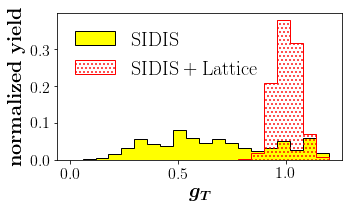

In [22]:
nrows,ncols=1,1
py.figure(figsize=(ncols*5,nrows*3))

ax=py.subplot(nrows,ncols,1)
R=(0,1.2)
ax.hist(gT1,histtype='stepfilled',range=R\
    ,weights=run1.weights,bins=20\
    ,facecolor='Yellow',edgecolor='k'
    ,label=r'$\rm SIDIS$')
ax.hist(gT2,histtype='stepfilled',range=R\
    ,weights=run2.weights,bins=20,facecolor='none',edgecolor='r',hatch='...'\
    ,label=r'$\rm SIDIS+Lattice$')
ax.set_ylabel(r'$\boldsymbol{\rm normalized~yield}$',size=20)
ax.set_xlabel(r'$\boldsymbol{g_T}$',size=20)
ax.tick_params(axis='both', which='major', labelsize=16)
#ax.set_xticks([0,.2,.4,.6,.8,1])
ax.legend(frameon=False,fontsize=20,loc=2)
py.tight_layout()
#py.savefig('gallery/gT.pdf')

EgT1 = np.einsum('k,k',gT1,run1.weights)
SgT1 = np.einsum('k,k',(gT1-EgT1)**2,run1.weights)**0.5
EgT2 = np.einsum('k,k',gT2,run2.weights)
SgT2 = np.einsum('k,k',(gT2-EgT2)**2,run2.weights)**0.5

print 'gT1=%10.1f +/- %10.1f'%(EgT1,SgT1)
print 'gT2=%10.2f +/- %10.2f'%(EgT2,SgT2)